#Abstract

In [previous observations](https://github.com/kevinhhl/options-pricing-tools-and-trading-strategies/blob/main/Implied_Volatility_Term_Structure_(ATM_Skew).ipynb), we noticed that if implied volatility (IV) for an ATM option is higher than the long-term realized volatility, then it is reasonable to assume that IV should eventually revert to its long-term mean. When IV is high, near-the-money options tend to be overpriced relative to their theoretical values. We should be selling calls and puts during these market conditions.

Going with this proposition, we could consider the following procedures: 

* **Step 1**: Determine a reasonable range of where the price will likely sit on or before the date of expiration. 

* **Step 2**: Constructing a strangle according to the price interval (as identified in step 2), 

* **Step 3**: Check whether we have a positive theoretical edge. Do a sensitivity analysis on Delta, Gamma, Theta, and Vega to make note of our risk parameters.



##### Imports

In [1]:
# !pip install yahoo_fin
# !pip install yfinance

In [2]:
from yahoo_fin import options
import yfinance as yf 
import pandas as pd
from scipy.stats import norm
import math
from datetime import date, datetime
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import numpy as np

# Implementations

Can skip to Applications & Conclusion sections (parts labeled with "😎" are considered more important)





#####  **class BSM():**

In [3]:
class BSM:
  
  def __init__(self, x, s, t, r, sigma):
    self.d1, self.d2 = None, None
    self.tv_call, self.delta_call , self.gamma_call, self.vega_call, self.theta_call, self.rho_call = None, None, None, None, None, None
    self.tv_put, self.delta_put, self.gamma_put, self.vega_put, self.theta_put, self.rho_put = None, None, None, None, None, None
    self.x, self.s, self.t, self.r, self.sigma  = x, s, t, r, sigma
    self.calc()

  def calc(self):
    ''' Calculates all the theoretical and Greeks values for call and put. 
        Need to call calc() whenever new input is provided. 
    '''
    _a = math.log(self.s/ self.x)
    _b = (self.r+self.sigma**2/2)*self.t
    self.d1 = (_a+_b)/self.sigma*math.sqrt(self.t)
    self.d2 = self.d1 - self.sigma * math.sqrt(self.t)
    
    # Call: 
    self.tv_call    = self.s * norm.cdf(self.d1) - self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2)
    self.delta_call = norm.cdf(self.d1)
    self.gamma_call = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_call  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_call = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) - self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    self.rho_call   = 0.01*(self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(self.d2))
    
    # Put: 
    self.tv_put    = self.x * math.exp(-self.r*self.t)-self.s+self.tv_call
    self.delta_put = -norm.cdf(-self.d1)
    self.gamma_put = norm.pdf(self.d1)/(self.s*self.sigma*math.sqrt(self.t))
    self.vega_put  = 0.01*(self.s*norm.pdf(self.d1)*math.sqrt(self.t))
    self.theta_put = 0.01*(-(self.s*norm.pdf(self.d1)*self.sigma)/(2*math.sqrt(self.t)) + self.r*self.x*math.exp(-self.r*self.t)*norm.cdf(-self.d2))
    self.rho_put   = 0.01*(-self.x*self.t*math.exp(-self.r*self.t)*norm.cdf(-self.d2))



##### **class contract():**

In [4]:
class contract:

  def __init__(self, expiry_date, strike, contracttype, quoted_price):
    self.multiple = 100
    self.strike = strike
    self.contracttype=contracttype
    self.expiry_date = expiry_date
    self.price = quoted_price

  def __str__(self):
    return "{}_{}_{} @{}".format(self.expiry_date, self.strike, self.contracttype, self.price)

##### **class leg():**

In [5]:
class leg:

  def __init__(self, side, contract, size, date_today, s, r, sigma):
    self.side = side
    self.contract = contract
    self.size=size
    self.date_today = date_today
    self.spot = s
    self.riskfree_rate = r
    self.sigma = sigma
    t = (contract.expiry_date-date_today).days/365
    self.model = BSM(contract.strike, s,t,r,sigma)

    self.delta, self.rho, self.vega, self.theta, self.gamma = None, None, None, None, None
    self.premium, self.th_value = 0, 0
    self.edge = 0

    # int _coefficient, has three purposes:
    #   (1) +/-ve Delta for long call/put, but it's reversed from seller's perspective  
    #   (2) If buyer of contract:   +ve vega, -ve theta, +ve gamma
    #   (3) If seller of contract:  -ve vega, +ve theta, -ve gamma
    _coefficient = None
    if self.side == "long":
      _coefficient = 1
    elif self.side == "short":
      _coefficient = -1
    
    if contract.contracttype=="call":
      if self.side == "long":
        self.edge = (self.model.tv_call-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_call) * size 
      
      self.th_value += self.model.tv_call * size * _coefficient
      self.delta = self.model.delta_call * size  * _coefficient
      self.rho = self.model.rho_call * size      * _coefficient
      self.vega = self.model.vega_call * size    * _coefficient
      self.gamma = self.model.gamma_call * size  * _coefficient
      self.theta = self.model.theta_call * size  * _coefficient
    
    elif contract.contracttype=="put":
      if self.side == "long":
        self.edge = (self.model.tv_put-self.contract.price) * size 
      elif self.side == "short":
        self.edge = (self.contract.price-self.model.tv_put) * size 
      
      self.th_value += self.model.tv_put* size   * _coefficient
      self.delta = self.model.delta_put * size   * _coefficient
      self.rho = self.model.rho_put * size       * _coefficient
      self.vega = self.model.vega_put * size     * _coefficient
      self.gamma = self.model.gamma_put * size   * _coefficient
      self.theta = self.model.theta_put * size   * _coefficient
    
    self.premium = contract.price * size * -_coefficient

  def __str__(self):
    n_round= 4 
    return "{} [size={}]: Δ={},𝚪={},Θ={},V={},⍴={}".format(str(self.contract),self.size, \
      self.delta.round(n_round),self.gamma.round(n_round),self.theta.round(n_round),self.vega.round(n_round),self.rho.round(n_round))


##### **class position():**

In [6]:
class position:

  def __init__(self):
    self.list_leg = []
    self.total_delta, self.total_gamma, self.total_vega, self.total_theta, self.total_rho = 0, 0, 0 ,0 ,0
    self.total_premium = 0
    self.total_th_edge = 0
    self.total_th_value = 0

  def get_summary(self, rounding=4) -> dict:
    ''' Returns dict of {string:float}
    ''' 
    return {"Total delta" : round(self.total_delta,rounding),
            "Total gamma" : round(self.total_gamma,rounding),
            "Total vega"  : round(self.total_vega,rounding),
            "Total theta" : round(self.total_theta,rounding),
            "Total rho"   :round(self.total_rho,rounding),
            "Premium (paid)/received" : round(self.total_premium,rounding),
            "Th. Value" : round(self.total_th_value,rounding), 
            "Th. Edge"    : round(self.total_th_edge,rounding),
            }
  

  def add_leg(self, leg): 
    self.list_leg.append(leg)
    
    self.total_premium += leg.premium
    self.total_th_edge += leg.edge
    self.total_th_value += leg.th_value
    self.total_delta += leg.delta
    self.total_gamma += leg.gamma
    self.total_vega += leg.vega
    self.total_theta += leg.theta
    self.total_rho += leg.rho 


  def plot_parity(self, midpoint, step_range, showplot=False): 
    xy = {}
      
    for leg in self.list_leg:
      
      # coefficient; if "long" then 1; if "short" then -1
      if leg.side == "short":
        _coeff = -1 * leg.size
      elif leg.side == "long":
        _coeff = 1 * leg.size

      for i in step_range:
        spot = i+midpoint
        if spot not in xy:
          xy[spot] = 0

        if leg.contract.contracttype == "call":
          xy[spot] = xy[spot] + max(0,spot-leg.contract.strike) * _coeff + leg.premium
        elif leg.contract.contracttype == "put":
          xy[spot] = xy[spot] + max(0,leg.contract.strike-spot) * _coeff + leg.premium

    list_x, list_y = [],[]
    for key in xy:
      list_x.append(key)
      list_y.append(xy[key])

    if showplot:
      pd.DataFrame({"Spot":list_x, "Intrinsic Value":list_y } ).plot(x="Spot", y="Intrinsic Value")

    return (list_x, list_y)


  def plot_th_pl(self, midpoint, step_range, showplot=False): 
    list_x, list_y = [], []

    for i in step_range:
      _spot = midpoint + i 
      list_x.append(_spot)

      # replicating legs: all variables (except for spot) remain constant
      total_y = 0
      for e in self.list_leg:
        _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=e.date_today, s=_spot, r=e.riskfree_rate, sigma=e.sigma)
        total_y += _leg.th_value#(_leg.th_value + _leg.premium)

      list_y.append(total_y)

    if showplot:
      pd.DataFrame({ "Spot":list_x, "Theoretical PL":list_y} ).plot(x="Spot", y="Theoretical PL")
    
    return (list_x, list_y)


# Helper functions for  sensitivity analysis

#### Theoretical value vs Sigma

In [7]:
def sensit_edge_v_sigma(initial_spot, initial_sigma, step_sigma, step_range_multiplier, clip=True): 
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _sigma = sigma + i*step_sigma

    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=initial_spot, r=riskfree_rate, sigma=_sigma)
      tmp_pos.add_leg(_leg)

    _edge = tmp_pos.total_th_edge
    list_x.append(_sigma)
    list_y.append(_edge)
    if __tmp is not None and ((_edge > 0 and __tmp < 0) or (_edge < 0 and __tmp > 0)):
      list_zerocross.append(_sigma)
    __tmp = _edge

  df = pd.DataFrame({ "Sigma":list_x, "Theoretical Edge":list_y } )
  if clip:
    df = df[(df["Theoretical Edge"]>0) & (df["Sigma"]<1)] 
  print("X-intercepts (sigma): " + str(list_zerocross))
  df.plot(x="Sigma", y="Theoretical Edge");

#### Delta vs Spot

In [8]:
def sensit_delta_v_spot(initial_spot, step_spot, step_range_multiplier): 
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _spot = crnt_price + i*step_spot
    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)

    list_x.append(_spot)
    _delta = tmp_pos.total_delta
    list_y.append(_delta)
    if __tmp is not None and (_delta > 0 and __tmp < 0 or _delta < 0 and __tmp > 0):
      list_zerocross.append(_spot)
    __tmp = _delta

  df = pd.DataFrame({ "Spot":list_x, "Delta":list_y } ) 
  print("Delta neutral crossing points: " + str(list_zerocross))
  df.plot(x="Spot", y="Delta");
  assert len(list_zerocross) == 1
  return list_zerocross[0]

#### Gamma vs spot

In [9]:
def sensit_gamma_v_spot(initial_spot, step_spot, step_range_multiplier): 
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _spot = crnt_price + i*step_spot
    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)

    list_x.append(_spot)
    _gamma = tmp_pos.total_gamma
    list_y.append(_gamma)
    if __tmp is not None and (_gamma > 0 and __tmp < 0 or _gamma < 0 and __tmp > 0):
      list_zerocross.append(_spot)
    __tmp = _gamma

  df = pd.DataFrame({ "Spot":list_x, "Gamma":list_y } ) 
  print("X-intercepts: " + str(list_zerocross))
  df.plot(x="Spot", y="Gamma");

#### Vega vs spot

In [10]:
def sensit_vega_v_spot(initial_spot, step_spot, step_range_multiplier): 
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _spot = crnt_price + i*step_spot
    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)

    list_x.append(_spot)
    _vega = tmp_pos.total_vega
    list_y.append(_vega)
    if __tmp is not None and (_vega > 0 and __tmp < 0 or _vega < 0 and __tmp > 0):
      list_zerocross.append(_spot)
    __tmp = _vega

  df = pd.DataFrame({ "Spot":list_x, "Vega":list_y } ) 
  print("X-intercepts: " + str(list_zerocross))
  df.plot(x="Spot", y="Vega");

#### Theta vs spot

In [11]:
def sensit_theta_v_spot(initial_spot, step_spot, step_range_multiplier): 
  list_x, list_y = [], []
  list_zerocross = []
  __tmp = None

  for i in step_range_multiplier:
    _spot = crnt_price + i*step_spot
    tmp_pos = position() 
    for e in pos.list_leg:
      _leg = leg(side=e.side, contract=e.contract, size=e.size, date_today=date_today, s=_spot, r=riskfree_rate, sigma=sigma)
      tmp_pos.add_leg(_leg)

    list_x.append(_spot)
    _theta = tmp_pos.total_theta
    list_y.append(_theta)
    if __tmp is not None and (_theta > 0 and __tmp < 0 or _theta < 0 and __tmp > 0):
      list_zerocross.append(_spot)
    __tmp = _theta

  df = pd.DataFrame({ "Spot":list_x, "Theta":list_y } ) 
  print("X-intercepts: " + str(list_zerocross))
  df.plot(x="Spot", y="Theta");

# Other helper functions
* Methods for making API-calls to data provider [yahoo finance]
* Monte carlo simulations [random walk of price]

Helpers for Monte carlo simulators

In [12]:
def _mcs_subtask1(price_data, verbose, n_iters=10000):
  # Print basic stats: mean, var., and drift
  price_data = price_data["Close"]
  pc = np.log(1+price_data.pct_change()) 

  if verbose:
    sb.histplot(pc.iloc[1:])
    plt.title("Historical Log Returns")
    plt.xlabel("Log Returns (Daily)")
    plt.ylabel("Frequency");

  mean, var, stddev = pc.mean(), pc.var(), pc.std() 
  drift = mean - 0.5*var
  if verbose:
    print("mean={}, var={}, drift={}".format(mean, var, drift))

  # Determine how many periods to perform random walk:
  date_t0 = date_today
  date_tn = date_expire

  n_forecast = 0        # Counter++ for each business days existing in between t0 and tn
  _t0 = date_t0         # tmp var.
  while _t0 <= date_tn:
    n_forecast += 1
    _t0 += BDay(1)

  # Init. array[n_forecast][n_iters] of zeros 
  rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))
  sim_equity_curve = np.zeros_like(rand_returns)

  # Assume single asset porfolio. Value of portfolio on day 1 of forecast is the Adj. Close price on that date. 
  sim_equity_curve[0] = price_data[len(price_data)-1]

  # Perform random walk and plot
  for t in range(1,n_forecast):
      sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]
  
  return (n_forecast,sim_equity_curve,rand_returns,date_t0,date_tn)

def perform_mcs(price_data, verbose=False): 
  n_forecast,sim_equity_curve,rand_returns,date_t0,date_tn = _mcs_subtask1(price_data, verbose) 

  assert(sim_equity_curve.shape==rand_returns.shape)
  print("\n{}\nShape={}".format(symbol, sim_equity_curve.shape))
  if verbose:
    print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn))) 

  plt.figure(figsize=(10,5))
  plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);

  # Printing the reasonable ranges at every t+i 
  count = 0
  stdev_multi = 2

  for e in sim_equity_curve:
    std = e.std()
    mean = e.mean()
    lower_bound = (mean-stdev_multi*std).round(2)
    upper_bound = (mean+stdev_multi*std).round(2)
    if verbose:
      print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}".format(count, date_t0+BDay(count), std.round(2), mean.round(2), lower_bound, upper_bound))
    count += 1

  return (lower_bound, upper_bound)


Price data provided by yfinance

In [13]:
def get_price_data(symbol,lookback="1y"):
  data = yf.Ticker(symbol).history(period=lookback)
  crnt_price = data['Close'].iloc[-1] 
  date_today = data.index[len(data)-1]
  return (data,date_today,crnt_price)

Building dicts of {float strike:Contract Object}

In [14]:
def _populate_dict(yf_chain, contracttype): 
  out = {}
  for i in range(len(yf_chain)):
    x = yf_chain["Strike"][i]
    out[x] = contract(date_expire, x, contracttype, yf_chain["Last Price"][i])

  return out

def get_custom_chains(symbol, date_expire_str):
  original_calls = options.get_options_chain(symbol, date_expire_str)["calls"]
  original_puts = options.get_options_chain(symbol, date_expire_str)["puts"]
  calls = _populate_dict(original_calls, "call")
  puts = _populate_dict(original_puts, "put")
  return (calls, puts, original_calls, original_puts)

# 😎 Applications:

In [15]:
# 😎 Manual input 
symbol = "AAPL"

exp_dates = options.get_expiration_dates(symbol)
"Expiration dates: " + str(exp_dates)

"Expiration dates: ['July 7, 2023', 'July 14, 2023', 'July 21, 2023', 'July 28, 2023', 'August 4, 2023', 'August 11, 2023', 'August 18, 2023', 'September 15, 2023', 'October 20, 2023', 'November 17, 2023', 'December 15, 2023', 'January 19, 2024', 'March 15, 2024', 'June 21, 2024', 'September 20, 2024', 'December 20, 2024', 'January 17, 2025', 'June 20, 2025', 'December 19, 2025']"

In [16]:
date_expire_str = exp_dates[2]
"Chosen expiration date: " + date_expire_str

'Chosen expiration date: July 21, 2023'

In [17]:
riskfree_rate = math.e**(yf.Ticker("^TNX").history(period="1D")["Close"][0]/100)-1
riskfree_rate

0.039333874636206856

In [18]:
date_expire = datetime.strptime(date_expire_str, '%B %d, %Y').date()
data, date_today, crnt_price = get_price_data(symbol)
date_today = date(date_today.year, date_today.month, date_today.day) 
calls, puts, original_calls, original_puts = get_custom_chains(symbol,date_expire_str)
print("Underlying asset:\t{} @{} on {}".format(symbol, crnt_price.round(2), date_today.strftime("%B %d, %Y %H:%M") ))

Underlying asset:	AAPL @192.46 on July 03, 2023 00:00


# IV Lookup

In [19]:
def get_strike_near(s):
  '''
  Returns the strike price nearest to the current price
  '''
  _strikes = tuple(calls.keys())
  for i in range(len(_strikes)-1):
    if _strikes[i+1] >= s and _strikes[i] <= s:
      output = _strikes[i]
  return output

atm_strike = get_strike_near(crnt_price)
print("ATM Strike = "+str(atm_strike))

ATM Strike = 190.0


In [20]:
_sigma = original_calls[original_calls["Strike"] == atm_strike]["Implied Volatility"].tolist()[0].strip("%")
sigma = float(_sigma)/100
sigma

0.1963

# Step 1: Determining a reasonable range

Historical lookback, n=251

AAPL
Shape=(15, 10000)


C:\Users\kevli\AppData\Local\Temp\ipykernel_20136\893693202.py:23: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while _t0 <= date_tn:


Expecting price of underlying asset
 to be in between 168.62 to 222.91 when options expire.


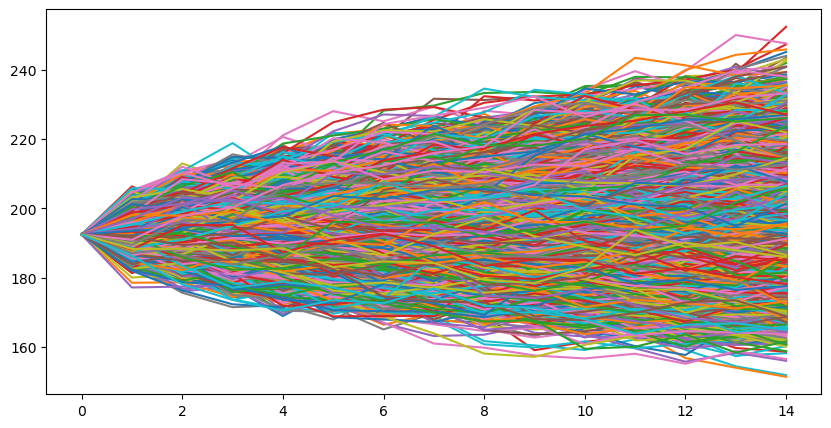

In [21]:
print("Historical lookback, n="+str(len(data)))
mcs_lower, mcs_upper = perform_mcs(data)

print("Expecting price of underlying asset\n to be in between {} to {} when options expire.".format(mcs_lower, mcs_upper))

# Step 2: Constructing the strangle 

In [22]:
lower_bound = get_strike_near(mcs_lower)
upper_bound = get_strike_near(mcs_upper) 

assert lower_bound in puts 
assert upper_bound in calls
(lower_bound, upper_bound)

(167.5, 220.0)

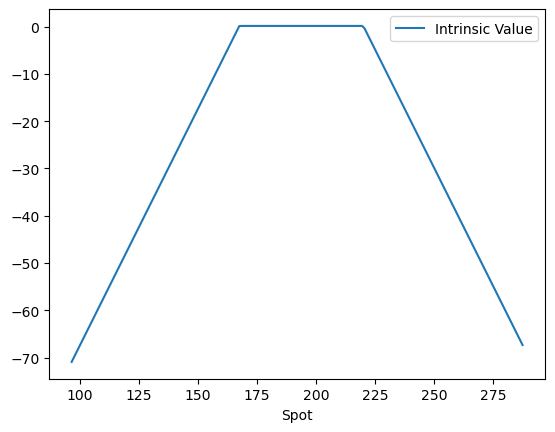

In [23]:
legs = (\
leg(side="short", contract=puts[lower_bound], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma), \
leg(side="short", contract=calls[upper_bound], size=1, date_today=date_today, s=crnt_price, r=riskfree_rate, sigma=sigma) \
)

pos = position()
for e in legs:
  pos.add_leg(e)

intrinsic_vals = pos.plot_parity(crnt_price, range(int(-crnt_price/2),int(crnt_price/2)), showplot=True) 

# Step 3: Sensitivity Analysis

In [24]:
pos.get_summary()

{'Total delta': -0.0049,
 'Total gamma': -0.094,
 'Total vega': -0.337,
 'Total theta': 0.6775,
 'Total rho': -0.0085,
 'Premium (paid)/received': 0.13,
 'Th. Value': 16.3497,
 'Th. Edge': 16.4797}

In [25]:
assert pos.total_th_edge  > 0

For a favorable position, we want:
* **-ve Vega,**
* **-ve Gamma, and**
* **+ve Theta**

In [26]:
assert pos.total_vega < 0
assert pos.total_gamma < 0
assert pos.total_theta > 0

## Delta v. Spot

Delta neutral crossing points: [191.4600067138672]


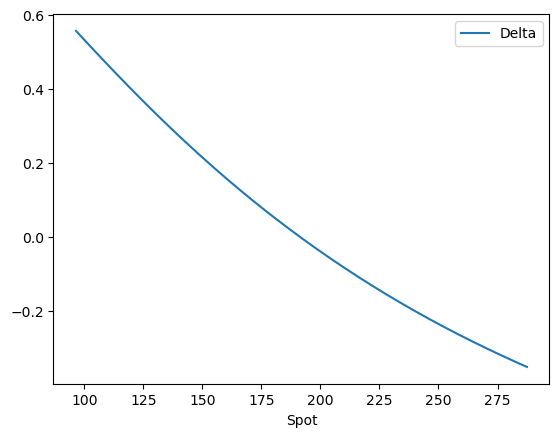

In [27]:
_x = int(crnt_price/2)
spot_dn = sensit_delta_v_spot(crnt_price, step_spot=1, step_range_multiplier=range(-_x,_x))

>This plot shows us that we are **not** exactly Delta neutral. 

In [28]:
print("To become delta neutral, spot price needs\n to move by {} (from {} to {}). \nAs usual, holding all other variables constant".format((spot_dn-crnt_price).round(2), crnt_price.round(2), spot_dn.round(2)))

To become delta neutral, spot price needs
 to move by -1.0 (from 192.46 to 191.46). 
As usual, holding all other variables constant


## Vega v. Spot

X-intercepts: []


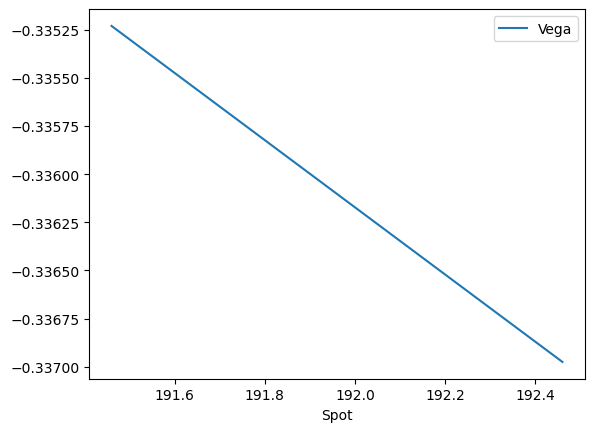

In [29]:
sensit_vega_v_spot(crnt_price, step_spot=1, step_range_multiplier=range(-1,1))

>As spot **rises**, vega **falls**, this is **favorable** 👍
>
>As spot **falls**, vega **rises**, this is **unfavorable** 👎

## Gamma v. Spot

X-intercepts: []


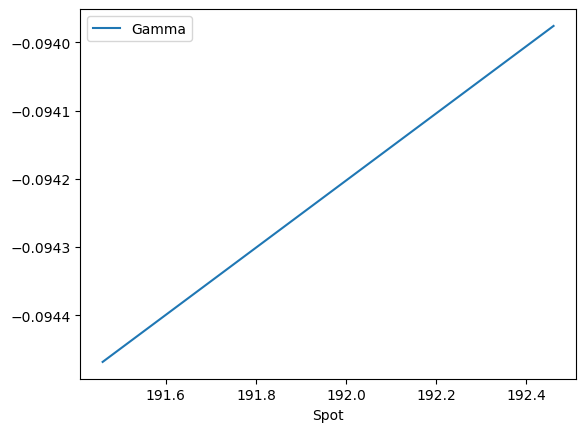

In [30]:
sensit_gamma_v_spot(crnt_price, step_spot=1, step_range_multiplier=range(-1,1))

>As spot **rises**, gamma **rises**, this is **unfavorable** 👎
>
>As spot **falls**, gamma **falls**, this is **favorable** 👍

## Theta v. Spot

X-intercepts: []


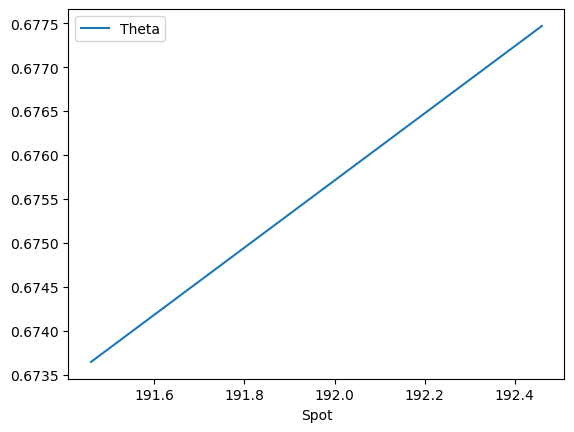

In [31]:
sensit_theta_v_spot(crnt_price, step_spot=1, step_range_multiplier=range(-1,1))

>As spot **rises**, theta **rises**, this is **favorable** 👍
>
>As spot **falls**, theta **falls**, this is **unfavorable** 👎

In summary, if the underlying price rises/falls, our Greeks are  affected, taking into consideration that we want: 
* -ve Vega,
* -ve Gamma, and
* +ve Theta

Then our overall position will also be affected:

|  |Vega ⬇️/⬆️  |Gamma ⬆️/⬇️  |Theta ⬆️/⬇️ |
|-----|----  |-----  |-----|
|**If Spot Rises**|👍 Favorable |👎 Unfavorable | 👍 Favorable |
|**If Spot Falls**|👎 Unfavorable |👍 Favorable | 👎 Unfavorable |

This analysis ignores magnitudes. 

[**Danger**] Downside:
* Unlimited losses. If the price rises to infinity, then we will be assigned to buy shares from the market at infinity to satisfy the obligations arising from the call contract sold (or forego the opportunity to sell shares at infinity if we already have the stocks in our portfolio).

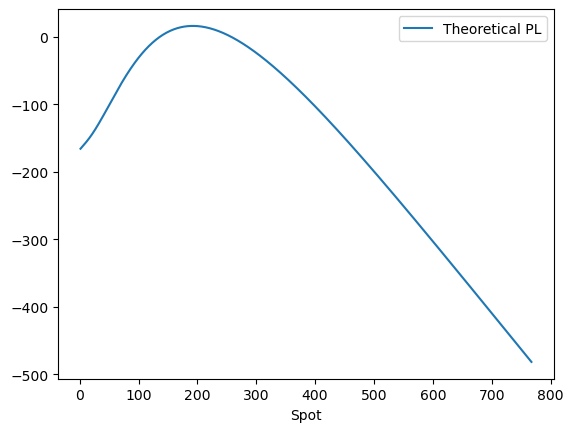

In [32]:
pos.plot_th_pl(crnt_price, range(int(-crnt_price)+1,int(crnt_price)*3), showplot=True);

>Example: In the unlikely event that price rises by 3x, or falls to zero, this is how the PL might look like.

# 😎 Theoretical edge v. Sigma


In the previous section, we found out: 

|  |Vega ⬇️/⬆️  |Gamma ⬆️/⬇️  |Theta ⬆️/⬇️ |
|-----|----  |-----  |-----|
|**If Spot Rises**|👍 Favorable |👎 Unfavorable | 👍 Favorable |
|**If Spot Falls**|👎 Unfavorable |👍 Favorable | 👎 Unfavorable |

This analysis ignores magnitudes. 


Holding Gamma and Theta constant, we know Vega is a big concern. If we receive updates in observed implied volatility, we will have to change Sigma in our model. This might affect our theoretical edge according to the following plot:

X-intercepts (sigma): []


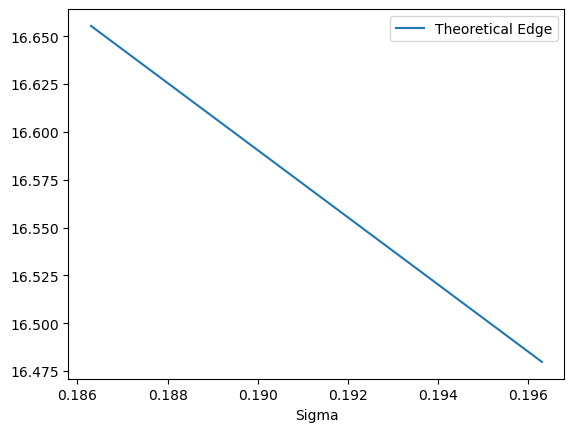

In [33]:
sensit_edge_v_sigma(crnt_price, sigma, step_sigma=0.01, step_range_multiplier=range(-1,1))

>As sigma **rises**, Th. Edge **falls**, this is **unfavorable** 👎
>
>As sigma **falls**, Th. Edge **rises**, this is **favorable** 👍

# 😎 Conclusion:

Recap:

In [34]:
str("{} currently trading @{}".format(symbol, crnt_price.round(2)))

'AAPL currently trading @192.46'

In [35]:
print("Options expiring: {}".format(date_expire_str))
for e in pos.list_leg:
  print(e)

Options expiring: July 21, 2023
2023-07-21_167.5_put @0.11 [size=1]: Δ=0.4363,𝚪=-0.0469,Θ=0.3052,V=-0.1683,⍴=0.0374
2023-07-21_220.0_call @0.02 [size=1]: Δ=-0.4412,𝚪=-0.047,Θ=0.3723,V=-0.1686,⍴=-0.0459


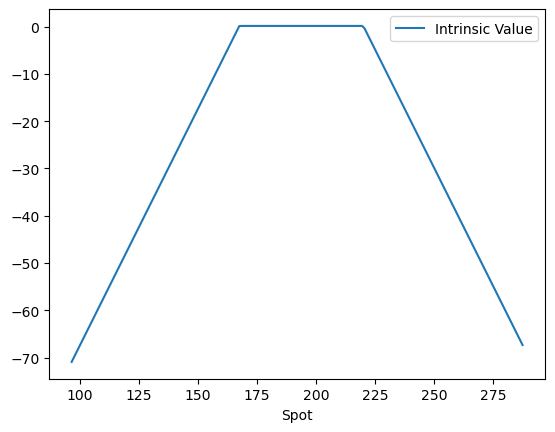

In [36]:
pos.plot_parity(crnt_price, range(int(-crnt_price/2),int(crnt_price/2)), showplot=True);

In [37]:
pos.get_summary()

{'Total delta': -0.0049,
 'Total gamma': -0.094,
 'Total vega': -0.337,
 'Total theta': 0.6775,
 'Total rho': -0.0085,
 'Premium (paid)/received': 0.13,
 'Th. Value': 16.3497,
 'Th. Edge': 16.4797}